Based on [_1](https://www.kaggle.com/suniliitb96/tutorial-keras-transfer-learning-with-resnet50) and [_2](https://www.kaggle.com/abhiksark/introduction-to-transfer-learning-cats-dogs)
# Transfer learning
It is a machine learning method where a model developed for a task is reused as the starting point for a model on a second task.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os, cv2, random
from tqdm import tqdm
from random import shuffle

%matplotlib inline

####################
# Global Constants #
####################
TRAIN_DIR = '../input/dogs-vs-cats-redux-kernels-edition/train'
TEST_DIR = '../input/dogs-vs-cats-redux-kernels-edition/test'
NUM_CLASSES = 2
IMG_SIZE = 224
EPOCHS = 10

train_images = os.listdir(TRAIN_DIR)[:10000] # For testing purposes
test_images = os.listdir(TEST_DIR)

In [4]:
# Return one-hot array [cat, dog] of image
def label_img(img):
    word_label = img.split('.')[-3]
    if word_label == 'cat': return [1, 0]
    elif word_label == 'dog' : return [0, 1]

# Return a numpy array of train and test data
def create_train_data():
    training_data = []
    for img in tqdm(train_images):
        label = label_img(img)
        img_path = os.path.join(TRAIN_DIR, img)
        img = cv2.imread(img_path, cv2.IMREAD_ANYCOLOR)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        training_data.append([np.array(img), np.array(label)])
    shuffle(training_data)
    return training_data

def process_test_data():
    testing_data = []
    for img in tqdm(test_images):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
    shuffle(testing_data)
    return testing_data

training_data = create_train_data()
X = np.array([i[0] for i in training_data]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array([i[1] for i in training_data])

100%|██████████| 10000/10000 [00:34<00:00, 293.60it/s]


In [5]:
from keras.applications import ResNet50
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense

# Path of ResNet50 pre-trained weights except its TOP layer,
RESNET_WEIGHTS_PATH = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

model = Sequential()
model.add(ResNet50(include_top = False,
                   pooling = 'max',
                   weights = RESNET_WEIGHTS_PATH))
model.add(Dense(NUM_CLASSES, activation= 'softmax'))
model.layers[0].trainable = False

# Compile the Transfer Learning Model
sgd = optimizers.SGD(lr = 1e-3, decay = 1e-6, momentum = 0.1, nesterov=True)
model.compile(optimizer= sgd, loss = 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


## Training

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 80s 10ms/step - loss: 0.6926 - acc: 0.9000 - val_loss: 0.2219 - val_acc: 0.9675

Epoch 00001: val_loss improved from inf to 0.22193, saving model to BestModel.hdf5
Epoch 2/10
8000/8000 [==============================] - 77s 10ms/step - loss: 0.1781 - acc: 0.9634 - val_loss: 0.2063 - val_acc: 0.9705

Epoch 00002: val_loss improved from 0.22193 to 0.20626, saving model to BestModel.hdf5
Epoch 3/10
8000/8000 [==============================] - 77s 10ms/step - loss: 0.1611 - acc: 0.9696 - val_loss: 0.2016 - val_acc: 0.9705

Epoch 00003: val_loss improved from 0.20626 to 0.20164, saving model to BestModel.hdf5
Epoch 4/10
8000/8000 [==============================] - 77s 10ms/step - loss: 0.1264 - acc: 0.9734 - val_loss: 0.1901 - val_acc: 0.9710

Epoch 00004: val_loss improved from 0.20164 to 0.19011, saving model to BestModel.hdf5
Epoch 5/10
8000/8000 [==============================] - 77s 

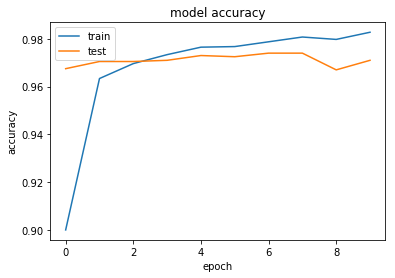

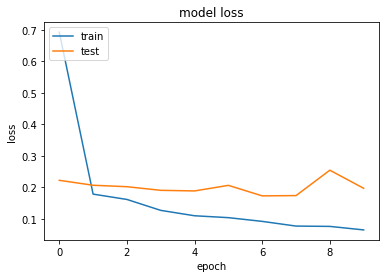

In [6]:
from keras.callbacks import ModelCheckpoint
check_point = ModelCheckpoint('BestModel.hdf5', verbose=True, save_best_only=True)
history = model.fit(X, y,
                    validation_split=0.2,
                    callbacks = [check_point],
                    epochs=EPOCHS,
                    batch_size=80,
                    verbose=1)

# Plotting loss and accuracy for the model
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Testing

/opt/conda/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg/keras/engine/saving.py:328: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
100%|██████████| 12500/12500 [00:43<00:00, 285.69it/s]


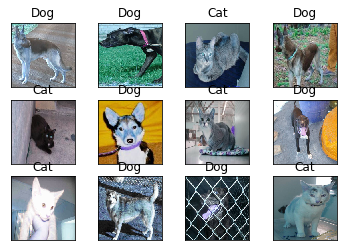

In [7]:
# Free some space
import gc
del X, y, training_data
gc.collect()

# Load Best model
from keras.models import load_model
model = load_model('BestModel.hdf5')

# Testing Model on Test Data
test_data = process_test_data()
fig =plt.figure()
for num, data in enumerate(test_data[:12]):
    # Cat: [1, 0]
    # Dog: [0, 1]
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3, 4, num+1)
    data = img_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1 : str_label ='Dog'
    else: str_label = 'Cat'
    y.imshow(img_data)
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False);
    y.axes.get_yaxis().set_visible(False);
plt.show()

## Generate .csv for submission

In [8]:
prob = []
img_list = []
for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(-1,IMG_SIZE,IMG_SIZE,3)
        model_out = model.predict([data])[0]
        img_list.append(img_num)
        prob.append(model_out[1])
    
submission = pd.DataFrame({'id':img_list , 'label':prob})
print(submission.head())
submission.to_csv("submit.csv", index=False)

100%|██████████| 12500/12500 [05:25<00:00, 38.49it/s]


      id         label
0   9997  1.000000e+00
1  12362  1.000000e+00
2   9205  2.151476e-13
3   6569  1.000000e+00
4  11410  4.098497e-10
